# Inversion of Frequency Domain EM data: Bookpurnong Australia

This example is based on the inversion published of RESOLVE data over Bookpurnong in [Heagy et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0098300416303946)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from scipy.constants import mu_0

from pymatsolver import Pardiso as Solver

from SimPEG import (
    Mesh, Maps, Utils, DataMisfit, Regularization, Optimization, 
    Inversion, InvProblem, Directives
)
from SimPEG.EM import FDEM

In [2]:
from matplotlib import rcParams
rcParams['font.size']=14

## Look at the contents of the data directory we are given

In [88]:
data_directory = os.path.sep.join(["..", "data", "bookpurnong"])
os.listdir(data_directory)

['MurrayRiver.txt',
 'booky_resolve.hdf5',
 '8044_Bookpurnong.HDR',
 'SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt',
 'booky_skytem.hdf5',
 'README.txt',
 'Bookpurnong_SkyTEM.HDR',
 'Bookpurnong_Resolve_Exported.XYZ']

### look at the README for a description of the files

In [4]:
# the os.path.sep.join combines the "bookpurnong" and "README.txt" with the 
# correct path seperator (e.g. on mac or linux, this will produce 
# "bookpurnong/README.txt")

with open(os.path.sep.join([data_directory, "README.txt"]), 'r') as file:
    print(file.read())

Bookpurnong Data Sets

The RESOLVE and SkyTEM data collected over Bookpurnong have been made available with permission from CSIRO. Please acknowledge CSIRO if using these data in a presentation, publication, etc.

Two data sets are included in this distribution, RESOLVE data collected in 2008, and SkyTEM (High Moment) data collected in 2006.

For an example of how to load and plot the data, please see: http://docs.simpeg.xyz


Contents
--------

- 8044_Bookpurnong.HDR : RESOLVE header file for the 2008 Bookpurnong survey
- Bookpurnong_Resolve_Exported.XYZ : RESOLVE data collected in 2008
- Bookpurnong_SkyTEM.HDR : SkyTEM header file for the 2006 Bookpurnong survey
- SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt : SkyTEM high moment data collected in 2006






### Load the resolve data

In [5]:
# Load RESOLVE (2008)
header = "Survey     Date   Flight      fid  utctime helicopter_easting helicopter_northing gps_height bird_easting bird_northing bird_gpsheight elevation bird_height bird_roll bird_pitch bird_yaw    em[0]    em[1]    em[2]    em[3]    em[4]    em[5]    em[6]    em[7]    em[8]    em[9]   em[10]   em[11]       Line "
header = header.split()
resolve = np.loadtxt(
    os.path.sep.join([data_directory, "Bookpurnong_Resolve_Exported.XYZ"]),
    skiprows=8
)
lines = np.unique(resolve[:, -1])


In [6]:
# Load path of Murray River
river_path = np.loadtxt(os.path.sep.join([data_directory, "MurrayRiver.txt"]))

In [7]:
def get_column_index(header_key, header=header):
    ind = None
    for i, key in enumerate(header): 
        if key == header_key:
            ind = i
    return ind

In [8]:
easting = resolve[:, get_column_index("bird_easting")]
northing = resolve[:, get_column_index("bird_northing")]

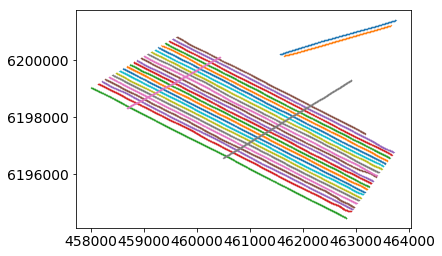

In [9]:
fig, ax = plt.subplots(1, 1)
for l in lines:
    inds = resolve[:, -1] == l
    ax.plot(easting[inds], northing[inds], '.', ms=0.5)

# ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)

In [10]:
lines

array([30001., 30002., 30010., 30030., 30040., 30050., 30060., 30070.,
       30080., 30090., 30100., 30110., 30120., 30130., 30140., 30151.,
       30160., 30170., 30180., 30190., 30200., 30210., 30220., 30230.,
       30240., 30250., 39010., 39020.])

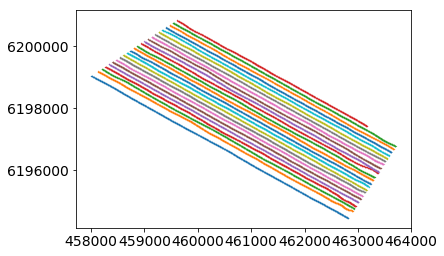

In [11]:
# Omit the tie lines
fig, ax = plt.subplots(1, 1)
for l in lines[2:-2]:
    inds = resolve[:, -1] == l
    ax.plot(easting[inds], northing[inds], '.', ms=0.5)

# ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)

In [12]:
tie_line_inds = (resolve[:, -1] <= lines[2]) | (resolve[:, -1] >= lines[-2])

In [13]:
data_header = "CPI400_F  CPQ400_F  CPI1800_F CPQ1800_F CXI3300_F CXQ3300_F CPI8200_F CPQ8200_F CPI40k_F  CPQ40k_F  CPI140k_F CPQ140k_F "
data_header = data_header.split()

xyz = resolve[~tie_line_inds, 8:11]
data = resolve[~tie_line_inds, 16:-1]

In [14]:
def plot_data(header_ind):
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    # grid the data
    nskip = 40
    out = Utils.plot2Ddata(xyz[::nskip, :2], data[::nskip, header_ind], ncontour=100, ax=ax)
    plt.colorbar(out[0], ax=ax, label="Bz (ppm)")
    
    # add the river path 
    ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)
    
    # labels
    ax.set_xlabel('easting (m)')
    ax.set_ylabel('northing (m)')
    
    # get title
    head = data_header[header_ind]
    orientation = head[:2]
    
    component = None
    if head[2] == "I":
        component = "in-phase" 
    elif head[2] == "Q":
        component = "quadrature"
    
    freq = head.split("_")[0][3:]
    
    ax.set_title(f"{orientation}, {freq}Hz {component}")
    return ax

In [15]:
ipywidgets.interact(
    plot_data, 
    header_ind = ipywidgets.IntSlider(min=0, max=len(data_header)-1, value=0)
)

interactive(children=(IntSlider(value=0, description='header_ind', max=11), Output()), _dom_classes=('widget-i…

<function __main__.plot_data(header_ind)>

## invert a single sounding

Here, we will invert a single sounding location for a layered earth and use a cylindrically symmetric mesh for the forward modelling. 

In [16]:
xloc, yloc = 462100.0, 6196500.0

In [17]:
rxind = np.argmin((xyz[:, 0]-xloc)**2+(xyz[:, 1]-yloc)**2)
print(rxind)

15007


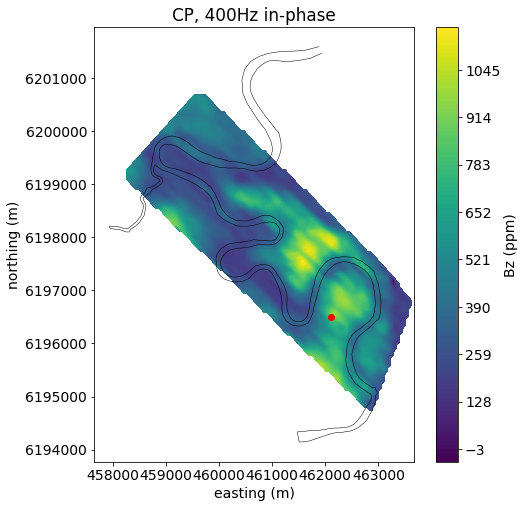

In [18]:
# plot the location
ax = plot_data(0)
ax.plot(xyz[rxind, 0], xyz[rxind, 1], 'ro')

For this inversion, we will only work with the coplanar_data. 

In [19]:
coplanar_inds = [False]*len(data_header)

for i, head in enumerate(data_header):
    if head.startswith("CP"):
        coplanar_inds[i] = True
        
coplanar_data = data[:, coplanar_inds]

Text(0, 0.5, 'Bz (ppm)')

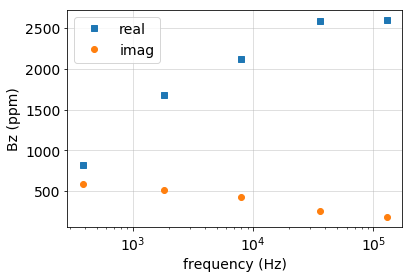

In [20]:
# plot the data - lets only work with the co-planar data set
frequencies = [382, 1822, 7970, 35920, 130100]
fig, ax = plt.subplots(1, 1)

for i, freq in enumerate(frequencies):
    # in phase is listed first
    ax.semilogx(freq, coplanar_data[rxind, i*2], 'C0s', ms=6)
    ax.semilogx(freq, coplanar_data[rxind, i*2 + 1], 'C1o', ms=6)
    ax.grid('-k', alpha=0.5)

ax.legend(["real", "imag"])
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Bz (ppm)")

### Set up a mesh

In [21]:
cs, ncx, ncz, npad = 1., 10., 10., 20
hx = [(cs, ncx), (cs, npad, 1.3)]
npad = 12
temp = np.logspace(np.log10(1.), np.log10(12.), 19)
temp_pad = temp[-1] * 1.3 ** np.arange(npad)
hz = np.r_[temp_pad[::-1], temp[::-1], temp, temp_pad]
mesh = Mesh.CylMesh([hx, 1, hz], '00C')
active = mesh.vectorCCz < 0.

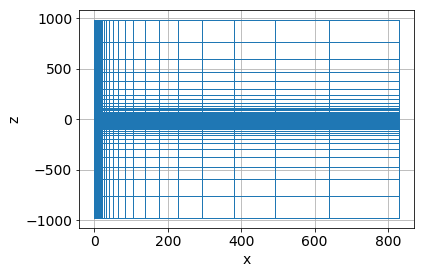

In [22]:
mesh.plotGrid()

In [23]:
sig_half = 1e-1
sig_air = 1e-8
active_inds = mesh.vectorCCz < 0.
active_map = Maps.InjectActiveCells(mesh, active_inds, np.log(sig_air), nC=mesh.nCz)
mapping = Maps.ExpMap(mesh) * Maps.SurjectVertical1D(mesh) * active_map


In [24]:
m0 = np.ones(active_inds.sum())*np.log(sig_half)

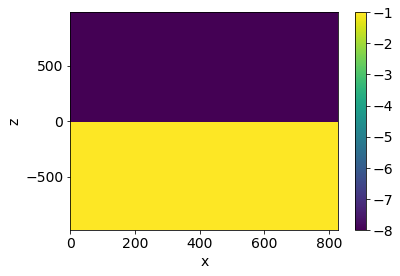

In [25]:
## plot the initial model

plt.colorbar(mesh.plotImage(np.log10(mapping*m0))[0])

### set up the forward simulation

In [29]:
# Bird height from the surface
bird_height = resolve[~tie_line_inds, get_column_index("bird_height")][rxind]

# Set Rx (In-phase and Quadrature)
rxOffset = 7.86

# The data are secondary field data
bzr = FDEM.Rx.Point_bSecondary(
    np.array([[rxOffset, 0., bird_height]]),
    orientation='z',
    component='real'
)

# there is no primary component that is imaginary
bzi = FDEM.Rx.Point_b(
    np.array([[rxOffset, 0., bird_height]]),
    orientation='z',
    component='imag'
)

In [30]:
src_list = []
src_loc = np.r_[0., 0., bird_height]

for freq in frequencies:
    src_list.append(
        FDEM.Src.MagDipole([bzr, bzi], freq, src_loc, orientation="Z")
    )

In [31]:
problem = FDEM.Problem3D_b(mesh, sigmaMap=mapping, Solver=Solver)
survey = FDEM.Survey(src_list)

problem.pair(survey)

### create data vector

For the frequency domain code, SimPEG expects either total magnetic flux values in teslas or secondary magnetic flux in teslas. Resolve data in units of ppm of the primary magnetic field, thus we need to compute the primary magnetic field (`b_primary`) and multiply the data we are provided by `1e6 b_primary`

In [48]:
b_primary = -mu_0/(4*np.pi*rxOffset**3)
data_to_invert = coplanar_data[rxind, :] * b_primary * 1e-6  # SimPEG expects the data in units of T (the file provides them in ppm)

In [49]:
data_to_invert

array([-1.68043810e-13, -1.21522858e-13, -3.44757528e-13, -1.04491948e-13,
       -4.35801852e-13, -8.83877493e-14, -5.31417957e-13, -5.26784396e-14,
       -5.36092705e-13, -3.65124603e-14])

In [50]:
%time
# run a forward simulation

dpred_0 = survey.dpred(m0)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


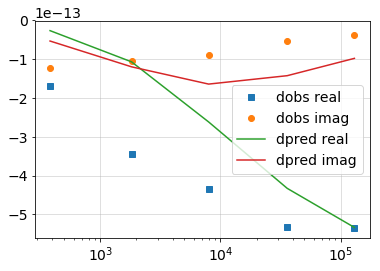

In [55]:
fig, ax = plt.subplots(1, 1)

ax.semilogx(frequencies, data_to_invert[::2], "C0s", label="dobs real")
ax.semilogx(frequencies, data_to_invert[1::2], "C1o", label="dobs imag")

ax.semilogx(frequencies, dpred_0[::2], "C2", label="dpred real")
ax.semilogx(frequencies, dpred_0[1::2], "C3", label="dpred imag")

ax.grid('k', alpha=0.5)
ax.legend()

### Data uncertainties

In [59]:
std = np.repeat(np.r_[np.ones(3)*0.1, np.ones(2)*0.15], 2)
floor = 20 * abs(b_primary) * 1e-6
uncert = abs(data_to_invert) * std + floor

In [64]:
survey.dobs = data_to_invert
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [70]:
# Regularization
reg_mesh = Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = Regularization.Simple(reg_mesh, mapping=Maps.IdentityMap(reg_mesh))


In [71]:
opt = Optimization.InexactGaussNewton(maxIter=10)

In [72]:
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

In [73]:
target = Directives.TargetMisfit()  # stop when we hit target misfit
invProb.beta = 2.
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = Inversion.BaseInversion(invProb, directiveList=[target])
reg.alpha_s = 1e-3
reg.alpha_x = 1.
reg.mref = m0.copy()
opt.LSshorten = 0.5
opt.remember('xc')
# run the inversion
mrec = inv.run(m0)



    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+00  1.24e+02  0.00e+00  1.24e+02    2.84e+01      0              
   1  2.00e+00  1.65e+01  2.91e+00  2.23e+01    1.06e+01      0              
   2  2.00e+00  5.18e+00  1.36e+00  7.90e+00    3.64e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.2510e+01
0 : |xc-x_last| = 2.4144e+00 <= tolX*(1+|x0|) = 1.3820e+00
0 : |proj(x-g)-x|    = 3.6362e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.6362e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      3

In [74]:
dpred = invProb.dpred

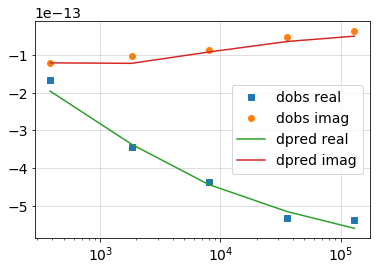

In [75]:
fig, ax = plt.subplots(1, 1)

ax.semilogx(frequencies, data_to_invert[::2], "C0s", label="dobs real")
ax.semilogx(frequencies, data_to_invert[1::2], "C1o", label="dobs imag")

ax.semilogx(frequencies, dpred[::2], "C2", label="dpred real")
ax.semilogx(frequencies, dpred[1::2], "C3", label="dpred imag")

ax.grid('k', alpha=0.5)
ax.legend()

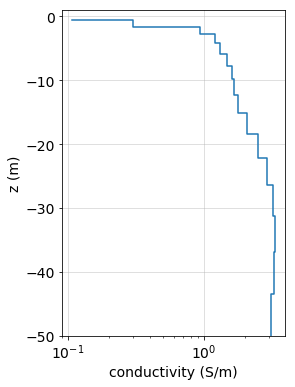

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

mplot = np.repeat(np.exp(mrec), 2, axis=0)
z = np.repeat(mesh.vectorCCz[active][1:], 2, axis=0)
ax.semilogx(mplot, np.r_[z[0], z, z[-1]])
ax.set_ylabel("z (m)")
ax.set_xlabel("conductivity (S/m)")
ax.set_ylim([-50, 1])
ax.grid('k', alpha=0.5)